# **Short-term Load Forecasting using Deep Learning**

# Connecting to Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Necessary Dependencies

In [1]:
import numpy as np
from math import sqrt
from pandas import read_csv
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline
from matplotlib import rcParams

from keras.callbacks import CSVLogger
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import Dropout

from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline
plt.rcParams.update({'font.size': 16})

# Helper Functions Defined

In [13]:
from keras.layers import Dropout
# split  dataset into train, validate and test sets
import numpy as np


def split_dataset(data, split_ratios=(0.7, 0.2, 0.1), daily_step=24, start=0):
    assert sum(split_ratios) == 1.0, "Split ratios must sum to 1.0"
    
    data = data[start:]
    total_timesteps = len(data)
    
    # Trim to full days
    total_trimmed = total_timesteps - (total_timesteps % daily_step)
    data = data[:total_trimmed]
    
    # Reshape into daily samples
    num_samples = total_trimmed // daily_step
    data_reshaped = np.reshape(data, (num_samples, daily_step, data.shape[1]))

    # Compute sizes
    n_train = int(num_samples * split_ratios[0])
    n_val = int(num_samples * split_ratios[1])
    n_test = num_samples - n_train - n_val

    train = data_reshaped[:n_train]
    val = data_reshaped[n_train:n_train + n_val]
    test = data_reshaped[n_train + n_val:]

    return train, val, test


# evaluate one or more daily forecasts against expected values
def evaluate_forecasts(actual, predicted, scaler):
	actual = scaler.inverse_transform(actual)
	predicted = scaler.inverse_transform(predicted)

	scores = list()
	# calculate an RMSE score for each hour of the day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store in scores list
		scores.append(rmse)
  
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs (actual) and outputs (predicted) for training
def convert_train_val(train, n_input, n_out=24):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step of 1 hour
		in_start += 1
	return np.array(X), np.array(y)

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1] that is 1 sample, sample data size, one feature
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next hour
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

def horizon_rolling_forecast(model, initial_input, X_test, forecast_horizon, input_window, scaler):
    preds = []
    current_input = initial_input.copy()
    total_chunks = len(X_test) // forecast_horizon

    for i in range(total_chunks):
        print(f"🔮 Forecast chunk {i + 1}/{total_chunks}", end='\r', flush=True)

        # Predict next horizon values
        pred = model.predict(current_input, verbose=0)[0]  # shape: (horizon,)
        preds.extend(pred.tolist())

        # Get real input features for next horizon
        x_next_chunk = X_test[i * forecast_horizon: (i + 1) * forecast_horizon]

        # If 3D, take last timestep per horizon step
        if x_next_chunk.ndim == 3:
            x_next_chunk = x_next_chunk[:, -1, :]  # shape: (horizon, features)

        # Exclude target column (assumed to be first column)
        x_next_features = x_next_chunk[:, 1:]  # shape: (horizon, feature_dim - 1)

        # Combine predicted target + real features
        pred_array = np.array(pred).reshape(forecast_horizon, 1)  # shape: (horizon, 1)
        combined = np.concatenate([pred_array, x_next_features], axis=1)  # shape: (horizon, feature_dim)

        # Update current input window
        current_input = np.concatenate([
            current_input.reshape(-1, current_input.shape[-1]),  # shape: (input_window, feature_dim)
            combined
        ], axis=0)

        # Trim to keep only last `input_window` steps and reshape to model input shape
        current_input = current_input[-input_window:].reshape(1, input_window, -1)

    preds = np.array(preds).reshape(-1, 1)
    return scaler.inverse_transform(preds).flatten()


def plot_iterative(true_vals, pred_vals, label="Model"):
    plt.figure(figsize=(30, 7))
    plt.plot(true_vals, label="True Values", color="blue", linewidth=0.5)
    plt.plot(pred_vals, label=f"Predicted by {label}", color="red", linewidth=0.5)
    plt.title(f"Iterative Forecast: {label}")
    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

def evaluate_all_forecasts(actual, predicted, scaler):
    """
    Evaluates forecasts and returns per-hour and overall:
    - MSE
    - MAE
    - MAPE

    Parameters:
    - actual: np.array of shape [days, hours]
    - predicted: np.array of shape [days, hours]

    Returns:
    - dict with overall and per-hour metrics
    """
    actual = scaler.inverse_transform(actual)
    predicted = scaler.inverse_transform(predicted)
    mse_scores, mae_scores, mape_scores = [], [], []

    # Per-hour scores
    for i in range(actual.shape[1]):
        y_true = actual[:, i]
        y_pred = predicted[:, i]

        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)

        mse_scores.append(mse)
        mae_scores.append(mae)
        mape_scores.append(mape)

    # Overall scores
    y_true_flat = actual.flatten()
    y_pred_flat = predicted.flatten()

    overall_mse = mean_squared_error(y_true_flat, y_pred_flat)
    overall_mae = mean_absolute_error(y_true_flat, y_pred_flat)
    overall_mape = mean_absolute_percentage_error(y_true_flat, y_pred_flat)

    return {
        'overall': {
            'mse': overall_mse,
            'mae': overall_mae,
            'mape': overall_mape
        },
        'per_hour': {
            'mse': mse_scores,
            'mae': mae_scores,
            'mape': mape_scores
        }
    }


# LSTM - Building Model Architecture and Training

In [15]:
# train the model
def build_model_LSTM(train, val, n_input, horizon):
	# Create training and validation sets
	train_x, train_y = convert_train_val(train, n_input, n_out=horizon)
	val_x, val_y = convert_train_val(val, n_input, n_out=horizon)

	print(f"Train shape: {train_x.shape}, {train_y.shape}")
	print(f"Validation shape: {val_x.shape}, {val_y.shape}")
	# define parameters
	csv_logger = CSVLogger('LSTM_Model_Logger.log')
	verbose, epochs, batch_size = 0, 30, 384
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	nv_timesteps, nv_features, nv_outputs = val_x.shape[1], val_x.shape[2], val_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))
	val_y = val_y.reshape((val_y.shape[0], val.shape[1]))
 
	# define model
	model = Sequential()
	model.add(LSTM(100, activation='relu', return_sequences=False, input_shape=(n_timesteps, 1)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(horizon))
	model.compile(loss='mse', optimizer='adam')
	print(model.summary())
	# fit network
	hist=model.fit(train_x, train_y, validation_data=(val_x, val_y),callbacks=[csv_logger], epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model, hist

# evaluate model fits model using training and validation data, then conducts a walk forwad validation with the test data
def evaluate_model_LSTM(train, val, test, n_input, horizon, scaler):
	# fit model
	model, hist = build_model_LSTM(train, val, n_input, horizon)
	# history is a list of houry data
	test_x, test_y = convert_train_val(test, n_input=n_input, n_out=horizon)
	# Predict in batch
	predictions = model.predict(test_x, verbose=0)
	# Ensure shape consistency
	if predictions.ndim == 3 and predictions.shape[-1] == 1:
		predictions = predictions[:, -1, :]
	# Evaluate predictions

	print(f"Predictions shape: {predictions.shape}, Test shape: {test_y.shape}")
	score, scores = evaluate_forecasts(test_y, predictions, scaler)
	results = evaluate_all_forecasts(test_y, predictions, scaler)
	plot_iterative(test_y[:, 0], predictions[:, 0], label="LSTM")
	return score, scores, hist, predictions, results, model

# CNN-LSTM - Building Model Architecture and Training

In [16]:
# Build and train CNN-BiLSTM model
def build_model_CNNLSTM(train, val, n_input, horizon):
	# Create training and validation sets
	train_x, train_y = convert_train_val(train, n_input, horizon)
	val_x, val_y = convert_train_val(val, n_input, horizon)
	# define parameters
	csv_logger = CSVLogger('CNNLSTM_Model_Logger.log')
	verbose, epochs, batch_size = 0, 30, 384
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	nv_timesteps, nv_features, nv_outputs = val_x.shape[1], val_x.shape[2], val_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	val_y = val_y.reshape((val_y.shape[0], val.shape[1], 1))
	# define model

	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(100, return_sequences=False, activation='relu', input_shape=(n_timesteps, 1)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(horizon))
	model.compile(loss='mse', optimizer='adam')
	print(model.summary())
	# fit network and store mse loss in hist 
	hist=model.fit(train_x, train_y, validation_data=(val_x, val_y),callbacks=[csv_logger], epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model, hist

# evaluate model fits model using training and validation data, then conducts a walk forwad validation with the test data
def evaluate_model_CNNLSTM(train, val, test, n_input, horizon, scaler):
	# fit model
	model, hist = build_model_CNNLSTM(train, val, n_input, horizon)
	# history is a list of houry data
	test_x, test_y = convert_train_val(test, n_input=n_input, n_out=horizon)
	# Predict in batch
	predictions = model.predict(test_x, verbose=0)
	# Ensure shape consistency
	if predictions.ndim == 3 and predictions.shape[-1] == 1:
		predictions = predictions[:, -1, :]
	# Evaluate predictions
	score, scores = evaluate_forecasts(test_y, predictions, scaler)
	results = evaluate_all_forecasts(test_y, predictions, scaler)
	plot_iterative(test_y[:, 0], predictions[:, 0], label="CNN-LSTM")
	return score, scores, hist, predictions, results, model

# BiLSTM - Building Model Architecture and Training

In [17]:
# Build and train BiLSTM model
def build_model_BiLSTM(train, val, n_input, horizon):
	# Create training and validation sets
	train_x, train_y = convert_train_val(train, n_input, horizon)
	val_x, val_y = convert_train_val(val, n_input, horizon)
	# define parameters
	csv_logger = CSVLogger('BiLSTM_Model_Logger.log')
	verbose, epochs, batch_size = 0, 30, 384
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	nv_timesteps, nv_features, nv_outputs = val_x.shape[1], val_x.shape[2], val_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	val_y = val_y.reshape((val_y.shape[0], val.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=False), input_shape=(n_timesteps, 1)))
	# model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
	#model.add(TimeDistributed(Dense(100, activation='relu')))
	#model.add(TimeDistributed(Dense(horizon)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(horizon))
	model.compile(loss='mse', optimizer='adam')
	print(model.summary())
	# fit network and store mse loss in hist 
	hist=model.fit(train_x, train_y, validation_data=(val_x, val_y),callbacks=[csv_logger], epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model, hist

# evaluate model fits model using training and validation data, then conducts a walk forwad validation with the test data
def evaluate_model_BiLSTM(train, val, test, n_input, horizon, scaler):
	# Fit model
	model, hist = build_model_BiLSTM(train, val, n_input, horizon)
	# Convert test set into input-output sequences
	test_x, test_y = convert_train_val(test, n_input=n_input, n_out=horizon)
	# Predict in batch
	predictions = model.predict(test_x, verbose=0)
	# Ensure shape consistency
	if predictions.ndim == 3 and predictions.shape[-1] == 1:
		predictions = predictions[:, -1, :]
	# Evaluate predictions

	print(f"Predictions shape: {predictions.shape}, Test shape: {test_y.shape}")
	score, scores = evaluate_forecasts(test_y, predictions, scaler)
	results = evaluate_all_forecasts(test_y, predictions, scaler)
	plot_iterative(test_y[:, 0], predictions[:, 0], label="BiLSTM")
	return score, scores, hist, predictions, results, model


# CNN-BiLSTM - Building Model Architecture and Training

In [18]:
# Build and train CNN-BiLSTM model
def build_model_CNNBiLSTM(train, val, n_input, horizon):
	# Create training and validation sets
	train_x, train_y = convert_train_val(train, n_input, horizon)
	val_x, val_y = convert_train_val(val, n_input, horizon)
	# define parameters
	csv_logger = CSVLogger('CNNBiLSTM_Model_Logger.log')
	verbose, epochs, batch_size = 0, 30, 384
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	nv_timesteps, nv_features, nv_outputs = val_x.shape[1], val_x.shape[2], val_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	val_y = val_y.reshape((val_y.shape[0], val.shape[1], 1))
	# define model

	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=False), input_shape=(n_timesteps, 1)))
	#model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(Dense(100, activation='relu'))
	#model.add(TimeDistributed(Dense(horizon)))
	model.add(Dense(horizon))
	model.compile(loss='mse', optimizer='adam')
	print(model.summary())
	# fit network and store mse loss in hist 
	hist=model.fit(train_x, train_y, validation_data=(val_x, val_y),callbacks=[csv_logger], epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model, hist

# evaluate model fits model using training and validation data, then conducts a walk forwad validation with the test data
def evaluate_model_CNNBiLSTM(train, val, test, n_input, horizon, scaler):
	# fit model
	model, hist = build_model_CNNBiLSTM(train, val, n_input, horizon)
	# history is a list of houry data
	# Convert test set into input-output sequences
	test_x, test_y = convert_train_val(test, n_input=n_input, n_out=horizon)
	# Predict in batch
	predictions = model.predict(test_x, verbose=0)
	# Ensure shape consistency
	if predictions.ndim == 3 and predictions.shape[-1] == 1:
		predictions = predictions[:, -1, :]

	score, scores = evaluate_forecasts(test_y, predictions, scaler)
	results = evaluate_all_forecasts(test_y, predictions, scaler)
	plot_iterative(test_y[:, 0], predictions[:, 0], label="CNN-BiLSTM")
	return score, scores, hist, predictions, results, model

# Load Dataset

In [19]:
dataset = read_csv('data/data.csv', header=0, 
                   infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

C:\Users\janav\AppData\Local\Temp\ipykernel_17352\1951696831.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataset = read_csv('data/data.csv', header=0,


# Data Decomposition into - Trend, Seasonality, and Noise

<Figure size 640x480 with 0 Axes>

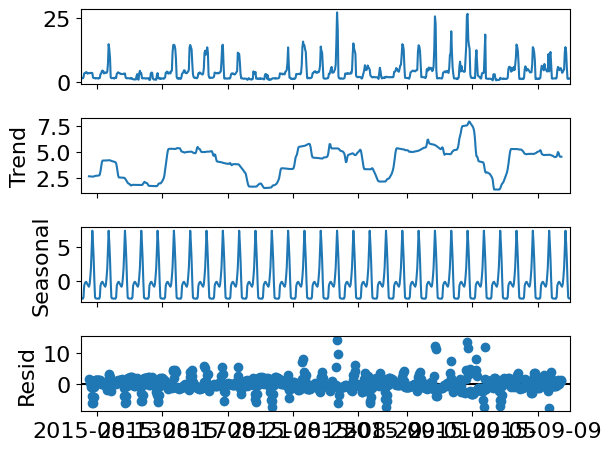

In [20]:
# Display and decompose data into trend, seasonality, noise
fig1 = plt.gcf()
month = dataset.iloc[0:720]
decomp = seasonal_decompose(month, model='additive')
decomp.plot()
plt.show()
fig1.savefig('seasonal_decompose.pdf')

# Normalization - Normalize data using min-max scaling

In [ ]:
#DONT RUN THIS PART, BECAUSE SCALING IS CAUSING DATA LEAKAGE

# trans = MinMaxScaler()
# dataset = trans.fit_transform(dataset)
# tran_scale = trans.scale_

# # split into train and test
# train, val, test = split_dataset(dataset)
# print('train size: ', train.shape)
# print('valid size: ', val.shape)
# print('test size : ', test.shape)

In [21]:
from sklearn.preprocessing import MinMaxScaler

# 1. Split raw dataset first (before scaling)
train, val, test = split_dataset(dataset, split_ratios=(0.6, 0.1, 0.3), daily_step=24, start=0)

# 2. Flatten training set to fit scaler (reshape to 2D: [samples * timesteps, features])
train_2d = train.reshape(-1, train.shape[-1])
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_2d)
train = train_scaled.reshape(train.shape)

# 3. Scale val and test using the same scaler (transform only)
val = scaler.transform(val.reshape(-1, val.shape[-1])).reshape(val.shape)
test = scaler.transform(test.reshape(-1, test.shape[-1])).reshape(test.shape)

# 5. Confirm shapes
print('train size: ', train.shape)
print('valid size: ', val.shape)
print('test size : ', test.shape)


train size:  (756, 24, 1)
valid size:  (126, 24, 1)
test size :  (379, 24, 1)


# Naive Forecasting Technique

In [22]:
# Perform naive prediction
N_actual= test[1:379]/tran_scale
N_predicted = test[0:378]/tran_scale 

N_score, N_scores = evaluate_forecasts(N_actual, N_predicted)

print('N_actual size: ', N_actual.shape)
print('Avg. score: ', N_score)

# summarize rmse scores
summarize_scores('rmse', N_score, N_scores)

N_actual size:  (378, 24, 1)
Avg. score:  6.037102980401384
rmse: [6.037] 2.8, 2.4, 2.5, 3.2, 3.1, 4.2, 5.7, 6.4, 6.9, 7.0, 6.7, 6.7, 6.2, 6.4, 7.0, 7.4, 8.6, 9.0, 8.7, 8.0, 6.8, 4.2, 2.8, 3.1


C:\Users\janav\AppData\Local\Temp\ipykernel_31316\1005511086.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = sqrt(s / (actual.shape[0] * actual.shape[1]))


## Lookback and Horizon

In [22]:
n_input = 24
horizon = 24

# LSTM Model Evaluation

Train shape: (18097, 24, 1), (18097, 24)
Validation shape: (2977, 24, 1), (2977, 24)


c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24)             │         2,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,324 (208.30 KB)

 Trainable params: 53,324 (208.30 KB)

 Non-trainable params: 0 (0.00 B)

None
Predictions shape: (9049, 24), Test shape: (9049, 24)


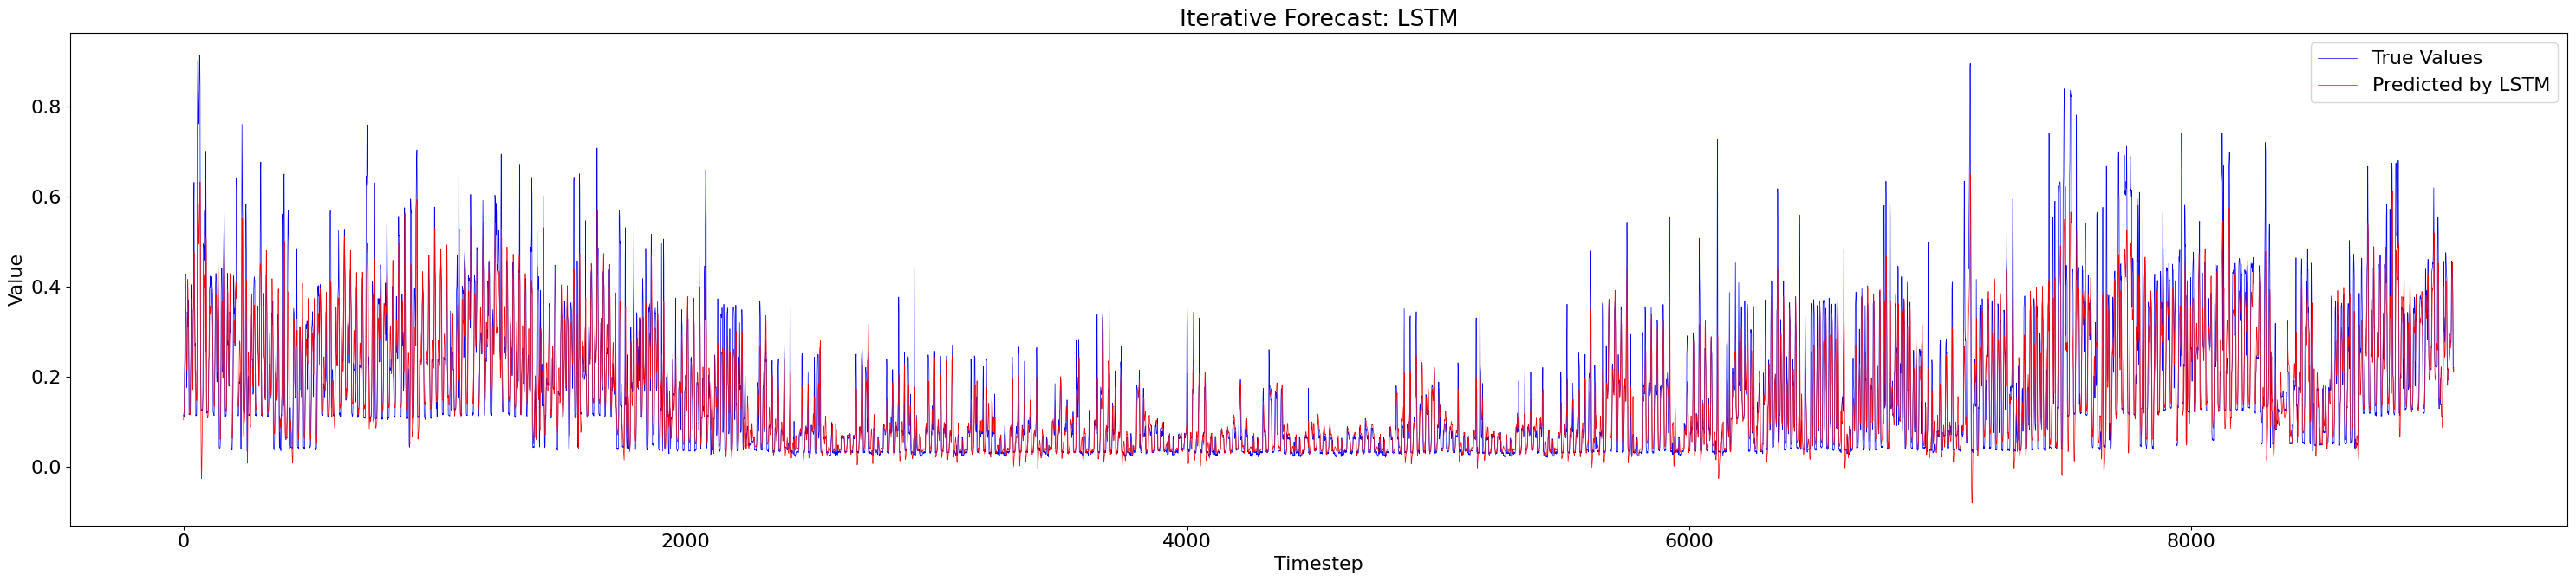

Avg. LSTM score:  5.384418504752213
Results:  {'overall': {'mse': 28.99196263431724, 'mae': 3.398368977624752, 'mape': 0.5547299273352422}, 'per_hour': {'mse': [14.162988924037633, 22.53202318281189, 27.66297485026272, 29.71404483187976, 31.02637228873742, 31.488610926308926, 33.10165724427261, 32.567989149601466, 31.972685347609524, 30.7929529866425, 30.439686760520985, 30.005154679569785, 29.57529752713841, 30.172608038719297, 30.278607025506176, 29.704550177069713, 29.280900691551995, 28.842598682239903, 29.035504811541035, 28.969946438160175, 29.22678259372826, 28.85386076556445, 28.09919180061106, 28.300113499527917], 'mae': [2.2931468223997054, 2.9501060323688937, 3.309254722071657, 3.4871636924049128, 3.5370656925836363, 3.547518586921012, 3.681220040511448, 3.651249377936971, 3.639788411240134, 3.6010742612511617, 3.5946224887016163, 3.544597631287266, 3.529292430033512, 3.497674211412388, 3.4041034278773195, 3.376214153878609, 3.3421730618250804, 3.323538891470542, 3.361113901

In [25]:
# evaluate model and get scores
LSTM_score, LSTM_scores, hist, predictions_LSTM, LSTM_results, LSTM_model = evaluate_model_LSTM(train, val, test, n_input, horizon, scaler)

print('Avg. LSTM score: ', LSTM_score)
print('Results: ', LSTM_results)

# summarize rmse scores
summarize_scores('rmse', LSTM_score, LSTM_scores)



# CNN-LSTM Model Evaluatiion

c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 22, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 24, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │       296,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 24)             │         2,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,532 (1.23 MB)

 Trainable params: 321,532 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

None


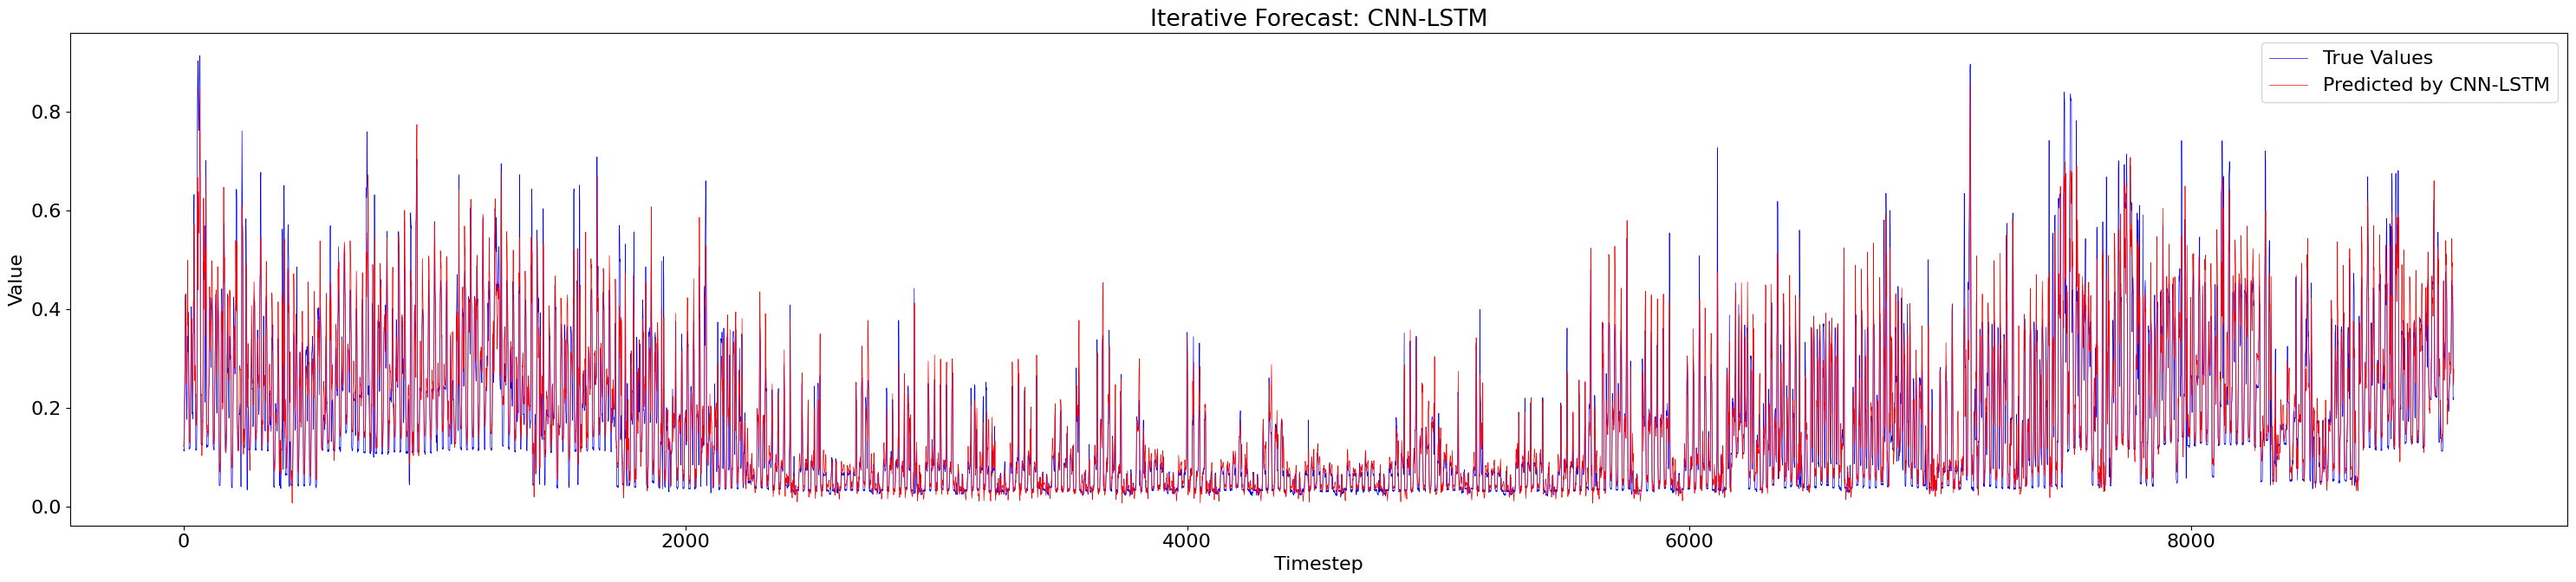

Avg. CNN-LSTM score:  5.317948650852734
Results:  {'overall': {'mse': 28.280577853105793, 'mae': 3.395906611203668, 'mape': 0.5840568312795914}, 'per_hour': {'mse': [12.152421641539489, 20.96929071892799, 25.789155086910906, 27.454990264611503, 29.13432732361972, 29.197018535392736, 29.823670532597564, 30.543322263953243, 30.252538461218062, 29.978440601779862, 30.953356791528584, 30.463115265317164, 30.431521592142108, 29.909990254382834, 29.00120005453974, 29.408752814077566, 29.33478868100181, 30.043068233163567, 28.983914636347528, 28.831891338715092, 28.958189716385498, 29.458259500177512, 28.36198642623401, 29.298657739975003], 'mae': [2.1908123265278117, 2.8827020954684612, 3.159718337747399, 3.3016609901434837, 3.4600845853223734, 3.3406598968238232, 3.399385239770884, 3.4480117538123123, 3.468641686576917, 3.4519301198375976, 3.5223191907969955, 3.518952741506337, 3.5320618166516717, 3.499019134553714, 3.477849144113566, 3.5657819614653854, 3.5373011611092613, 3.57263051743269

In [26]:
# evaluate model and get scores
CNNL_score, CNNL_scores, hist_CNNL, predictions_CNNL, CNNL_results, CNN_LSTM_model = evaluate_model_CNNLSTM(train, val, test, n_input, horizon, scaler)

print('Avg. CNN-LSTM score: ', CNNL_score)
print('Results: ', CNNL_results)

# summarize rmse scores
summarize_scores('rmse', CNNL_score, CNNL_scores)

# BiLSTM Model Evaluation

c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 200)            │        81,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 24)             │         2,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,124 (406.73 KB)

 Trainable params: 104,124 (406.73 KB)

 Non-trainable params: 0 (0.00 B)

None
Predictions shape: (9049, 24), Test shape: (9049, 24)


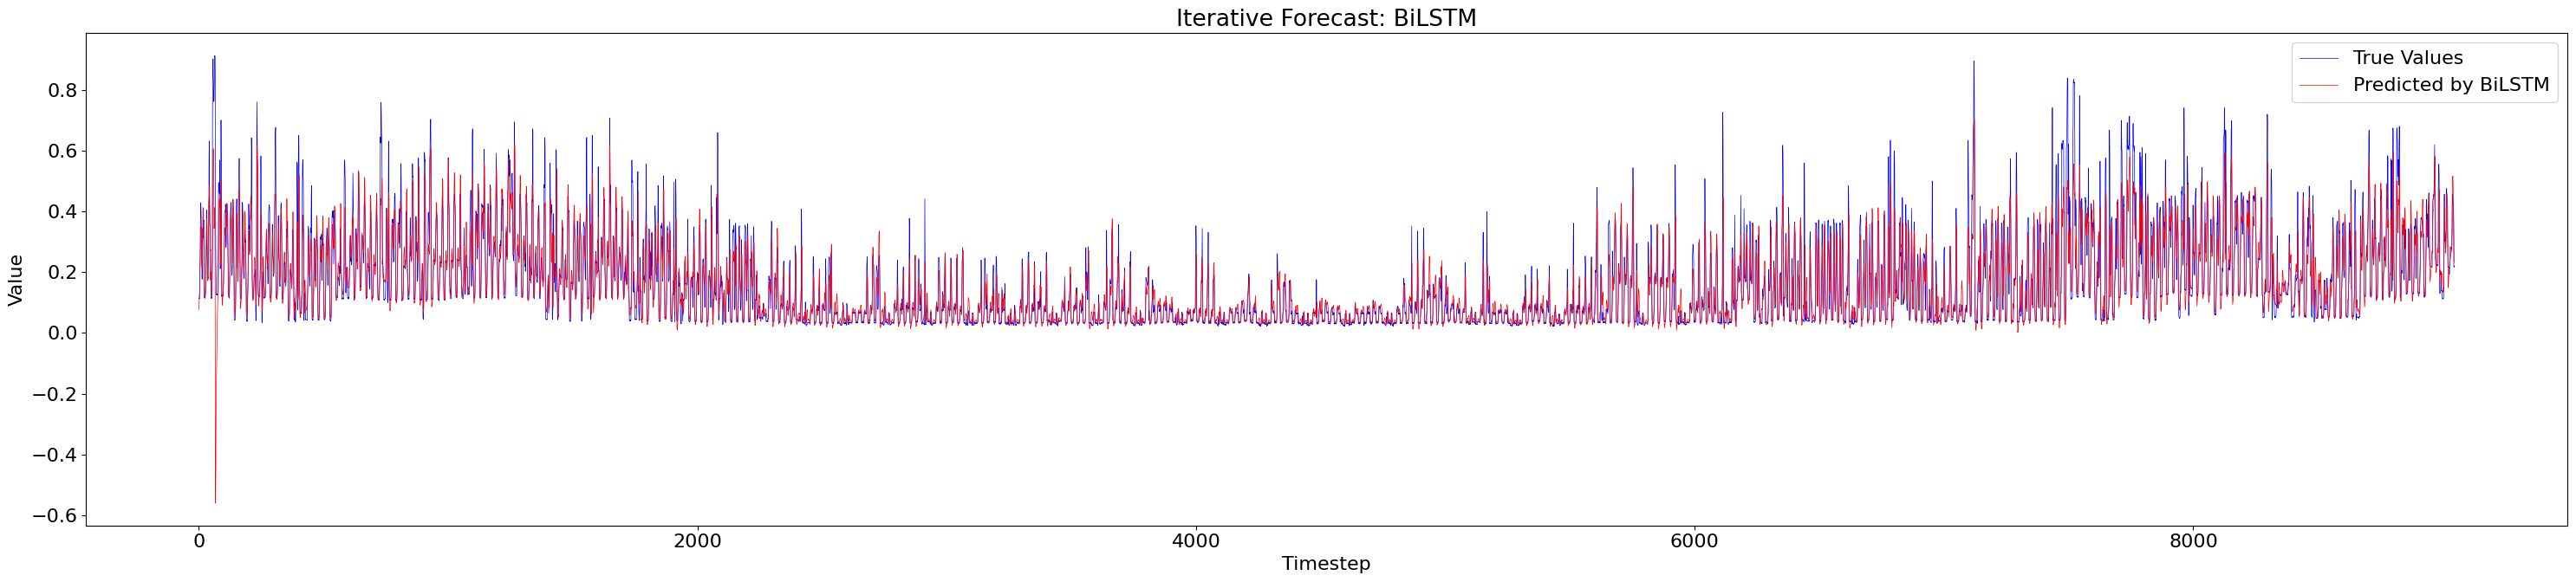

Avg. score:  5.378994228806248
Results:  {'overall': {'mse': 28.933578913530667, 'mae': 3.4039388280893115, 'mape': 0.5663484523623211}, 'per_hour': {'mse': [13.897661243715792, 21.83052224281264, 27.41619046111298, 29.655884669174363, 29.92398536224403, 32.28153083168217, 31.520479094843115, 30.246569167361333, 30.03141555618474, 30.569812273614442, 30.72724427783194, 31.042620943670723, 30.43445478805532, 31.466438744174425, 30.688052454937772, 29.308721516081793, 29.718505167670376, 30.482876889176335, 29.497530179894238, 29.06543668717835, 29.442807418687412, 28.36374946443264, 28.41650235266328, 28.376902137535918], 'mae': [2.178011816204243, 2.921168788129196, 3.2779616144300743, 3.534066580671614, 3.501619048439339, 3.5622667218131845, 3.533172775091362, 3.5596159296258354, 3.5571160326185565, 3.5512220012818876, 3.4758500300042336, 3.5188486326746387, 3.48304357958388, 3.525492296614612, 3.4908056123455076, 3.411558464378899, 3.441802087566552, 3.465894587035732, 3.471593076275

In [28]:
# evaluate model and get scores
BL_score, BL_scores, hist, predictions_BL, BL_results, BiLSTM_model = evaluate_model_BiLSTM(train, val, test, n_input, horizon, scaler)

print('Avg. score: ', BL_score)
print('Results: ', BL_results)

# summarize rmse scores
summarize_scores('rmse', BL_score, BL_scores)

# CNN-BiLSTM Model Evaluation

c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\janav\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 22, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 20, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 24, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200)            │       592,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 24)             │         2,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 627,932 (2.40 MB)

 Trainable params: 627,932 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

None


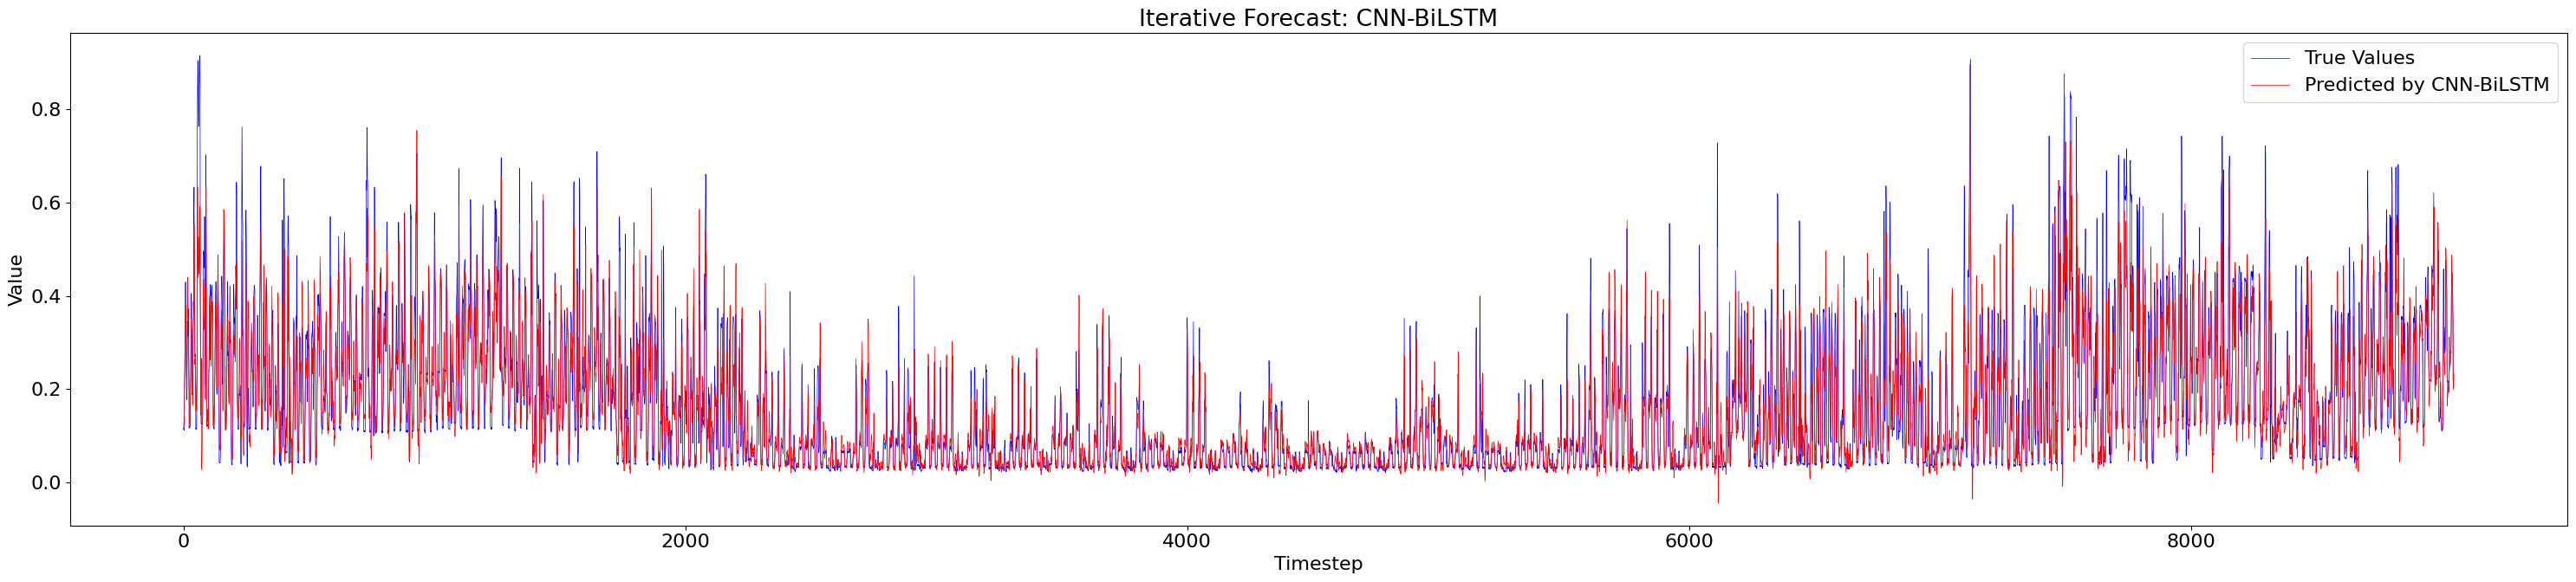

Avg. score:  5.542696505670276
Results:  {'overall': {'mse': 30.721484553968818, 'mae': 3.419011492971129, 'mape': 0.5477121996581273}, 'per_hour': {'mse': [12.997078001591003, 22.90466786794441, 27.19355048492995, 30.163021859483877, 30.81053206223991, 32.86923511608736, 33.30786865104482, 33.51284613439344, 34.87105278973519, 35.111277049624235, 35.405911319473276, 35.05355558625346, 34.26741648748093, 32.840746205062395, 31.371023921791597, 30.35717545376285, 30.191819391870837, 30.631580079932473, 31.31645529185762, 32.474309985077404, 30.379780927930167, 30.18584532322471, 29.708346268437545, 29.39053303602219], 'mae': [2.192766672452915, 2.89748707664985, 3.142604882512223, 3.3448288313317858, 3.442599992378661, 3.4887306471925044, 3.5641045128045024, 3.592423104621723, 3.6216200425096843, 3.6549100616407153, 3.6052508998556765, 3.6369113888149216, 3.627346218687021, 3.556477991995765, 3.4725801085518113, 3.468992731977497, 3.4530229753792177, 3.52271446005908, 3.527927144722553,

In [29]:
# evaluate model and get scores
CNNBL_score, CNNBL_scores, hist, predictions_CNNBL, CNNBL_results, CNN_BiLSTM_model = evaluate_model_CNNBiLSTM(train, val, test, n_input, horizon, scaler)

print('Avg. score: ', CNNBL_score)
print('Results: ', CNNBL_results)

# summarize rmse scores
summarize_scores('rmse', CNNBL_score, CNNBL_scores)

# Comparative Study - Plot an example prediction of each model for one day

In [31]:
### Taking 24 hours interval for the day-ahead load forecasting
hours = ['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12','13', '14', '15', '16', '17', '18', '19','20', '21', '22', '23', '24' ]

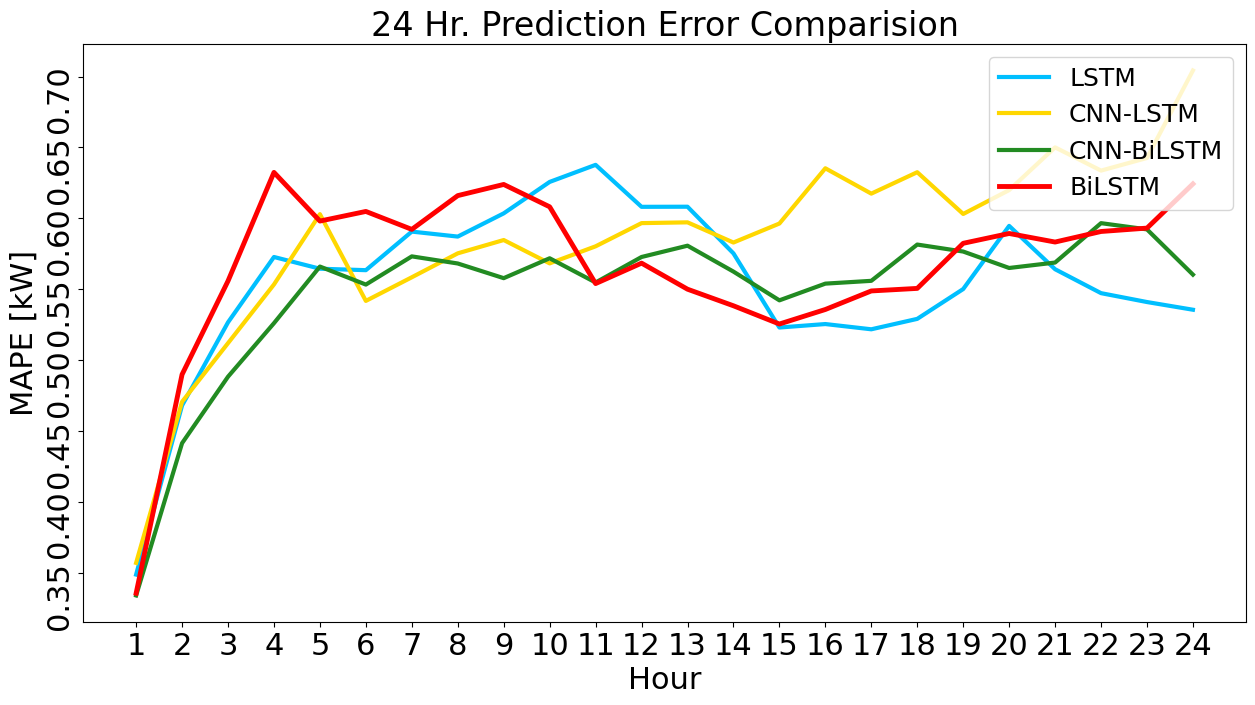

In [36]:
# fig2 = plt.gcf()
plt.figure(figsize=(15, 7.5))
#plt.plot(hours, N_scores, 'blue', label='Naive', linewidth=3)
plt.plot(hours, LSTM_results['per_hour']['mape'], 'deepskyblue', label='LSTM', linewidth=3)
plt.plot(hours, CNNL_results['per_hour']['mape'], 'gold', label='CNN-LSTM', linewidth=3)
plt.plot(hours, CNNBL_results['per_hour']['mape'], 'forestgreen', label='CNN-BiLSTM', linewidth=3)
plt.plot(hours, BL_results['per_hour']['mape'], 'r', label='BiLSTM', linewidth=3.5)
plt.title('24 Hr. Prediction Error Comparision', fontsize=24)
plt.xlabel("Hour", fontsize=22)
plt.ylabel("MAPE [kW]", fontsize=22)
plt.legend(loc='upper right', fontsize=18)
plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=90)

plt.savefig('RMSE-comparision.pdf')

In [40]:
_, N_actual = convert_train_val(test, n_input=n_input, n_out=horizon)
N_actual = scaler.inverse_transform(N_actual)
predictions_LSTM = scaler.inverse_transform(predictions_LSTM)
predictions_CNNL = scaler.inverse_transform(predictions_CNNL)
predictions_BL = scaler.inverse_transform(predictions_BL)
predictions_CNNBL = scaler.inverse_transform(predictions_CNNBL)


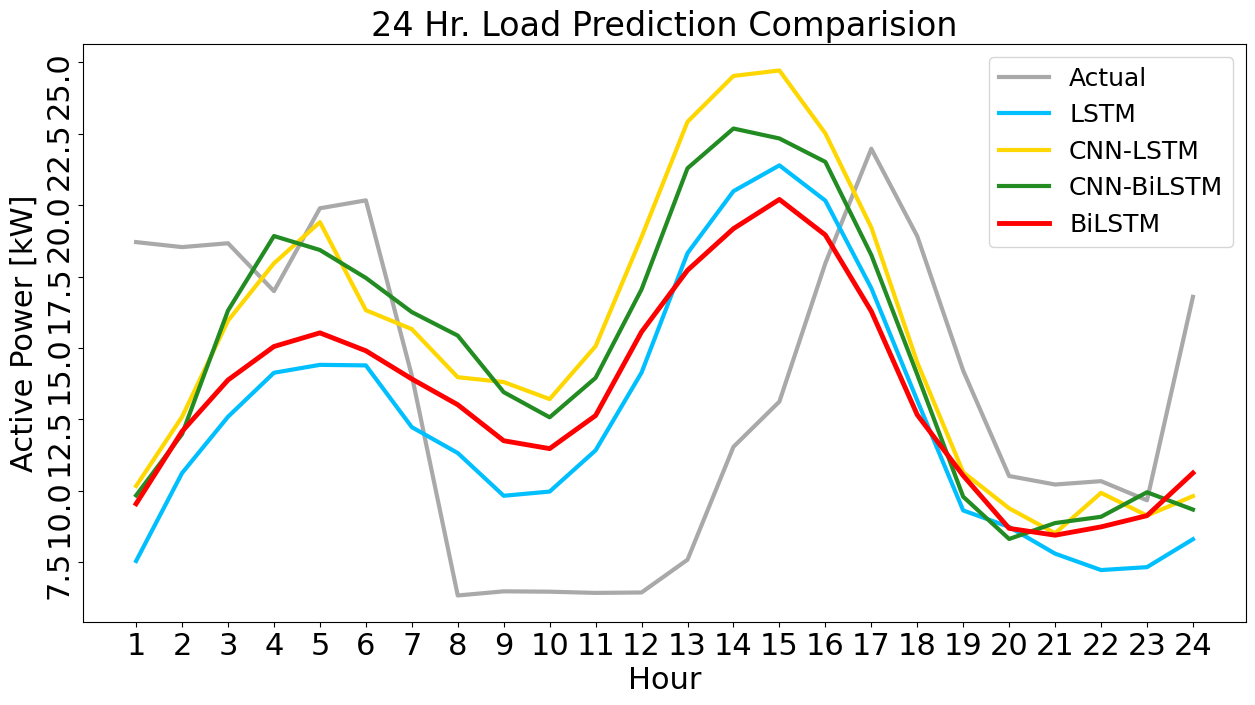

In [47]:
# fig3 = plt.gcf()
plt.figure(figsize=(15, 7.5))
plt.plot(hours, N_actual[15], 'darkgrey', label='Actual', linewidth=3)
#plt.plot(hours, N_predicted[15], 'b', label='Naive', linewidth=3)
plt.plot(hours, predictions_LSTM[28], 'deepskyblue', label='LSTM', linewidth=3)
plt.plot(hours, predictions_CNNL[28], 'gold', label='CNN-LSTM', linewidth=3)
plt.plot(hours, predictions_CNNBL[28], 'forestgreen', label='CNN-BiLSTM', linewidth=3)
plt.plot(hours, predictions_BL[28], 'r', label='BiLSTM', linewidth=3.5)
plt.title('24 Hr. Load Prediction Comparision', fontsize=24)
plt.xlabel("Hour", fontsize=22)
plt.ylabel("Active Power [kW]", fontsize=22)
plt.legend(loc='upper right', fontsize=18)
plt.xticks(fontsize=22, rotation=0)
plt.yticks(fontsize=22, rotation=90)

plt.savefig('model-predictions-comparision.pdf')

In [42]:
models = [('lstm', LSTM_model), ('cnn_lstm', CNN_LSTM_model), ('bilstm', BiLSTM_model), ('cnn_bilstm', CNN_BiLSTM_model)]
for name, model in models:
    model.save(f"models/{name}.h5")


Evaluating lstm with horizon rolling forecast...
🔁 Running iterative forecast for lstm with input_window=24, forecast_horizon=24


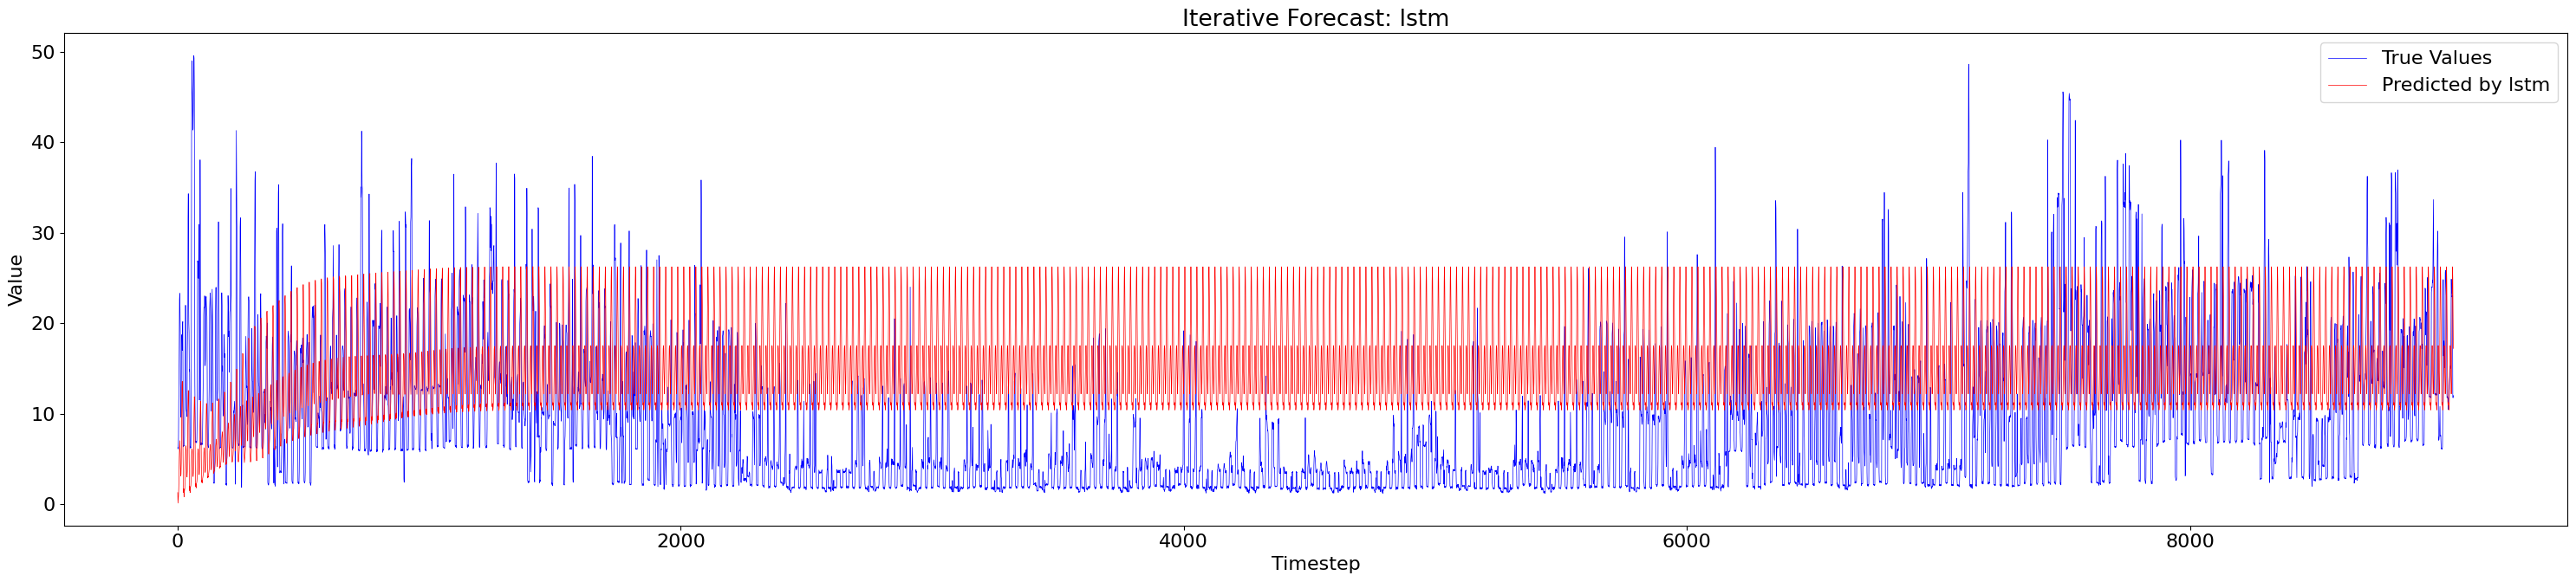

📊 Evaluation Metrics for lstm:
MAE:  8.4196
RMSE: 10.7912
MAPE: 96.67%
Evaluating cnn_lstm with horizon rolling forecast...
🔁 Running iterative forecast for cnn_lstm with input_window=24, forecast_horizon=24


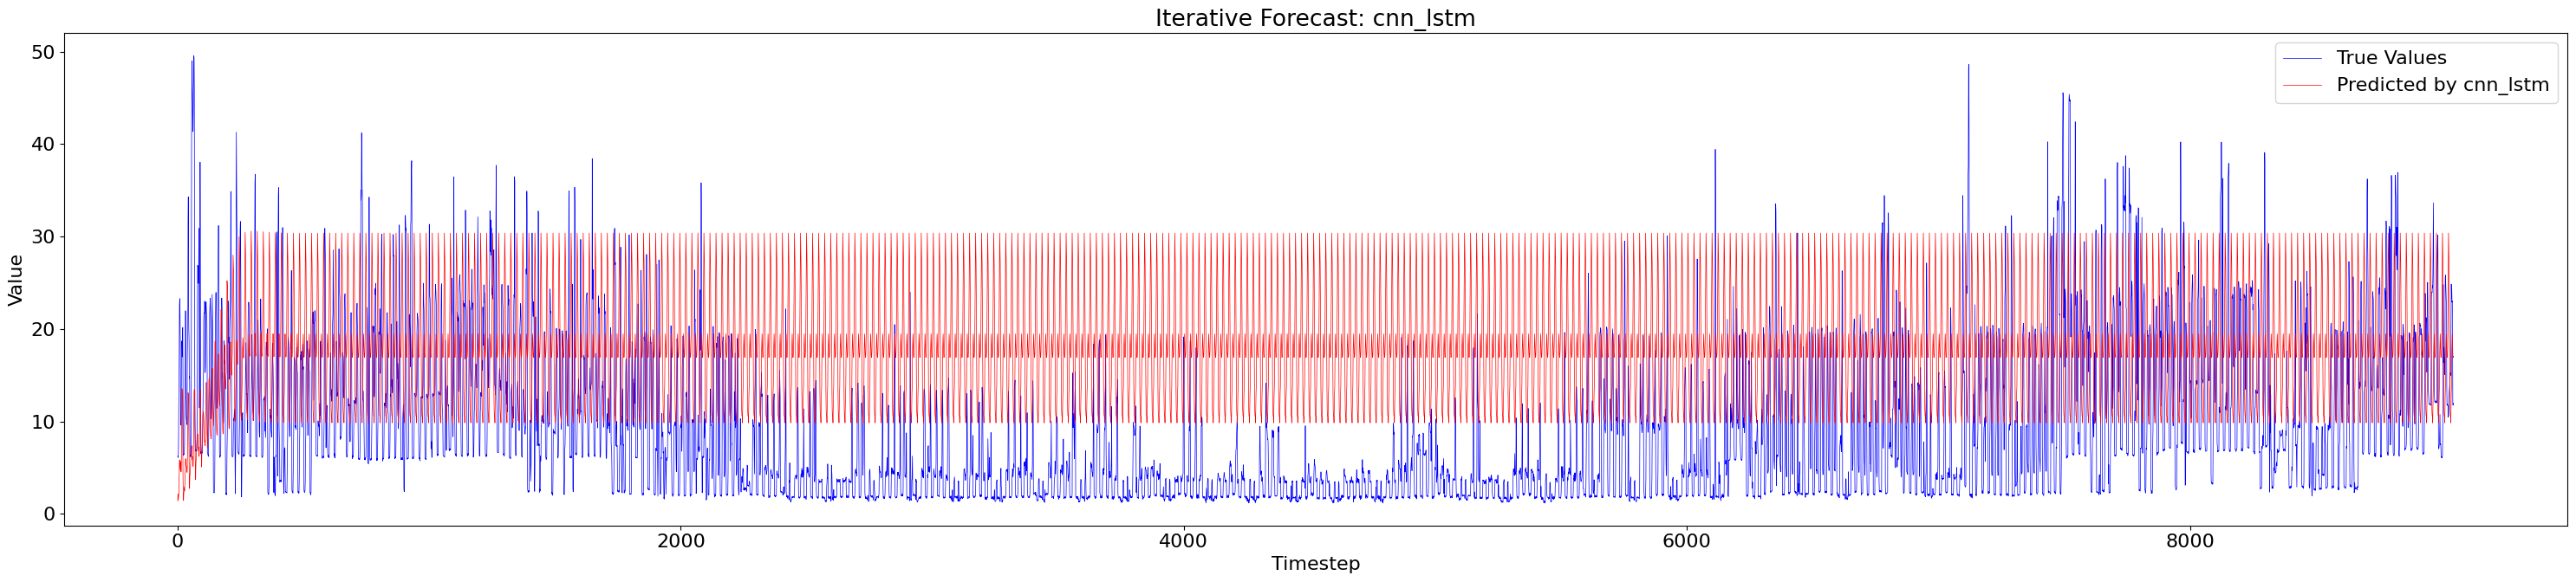

📊 Evaluation Metrics for cnn_lstm:
MAE:  9.3207
RMSE: 11.6106
MAPE: 114.51%
Evaluating bilstm with horizon rolling forecast...
🔁 Running iterative forecast for bilstm with input_window=24, forecast_horizon=24


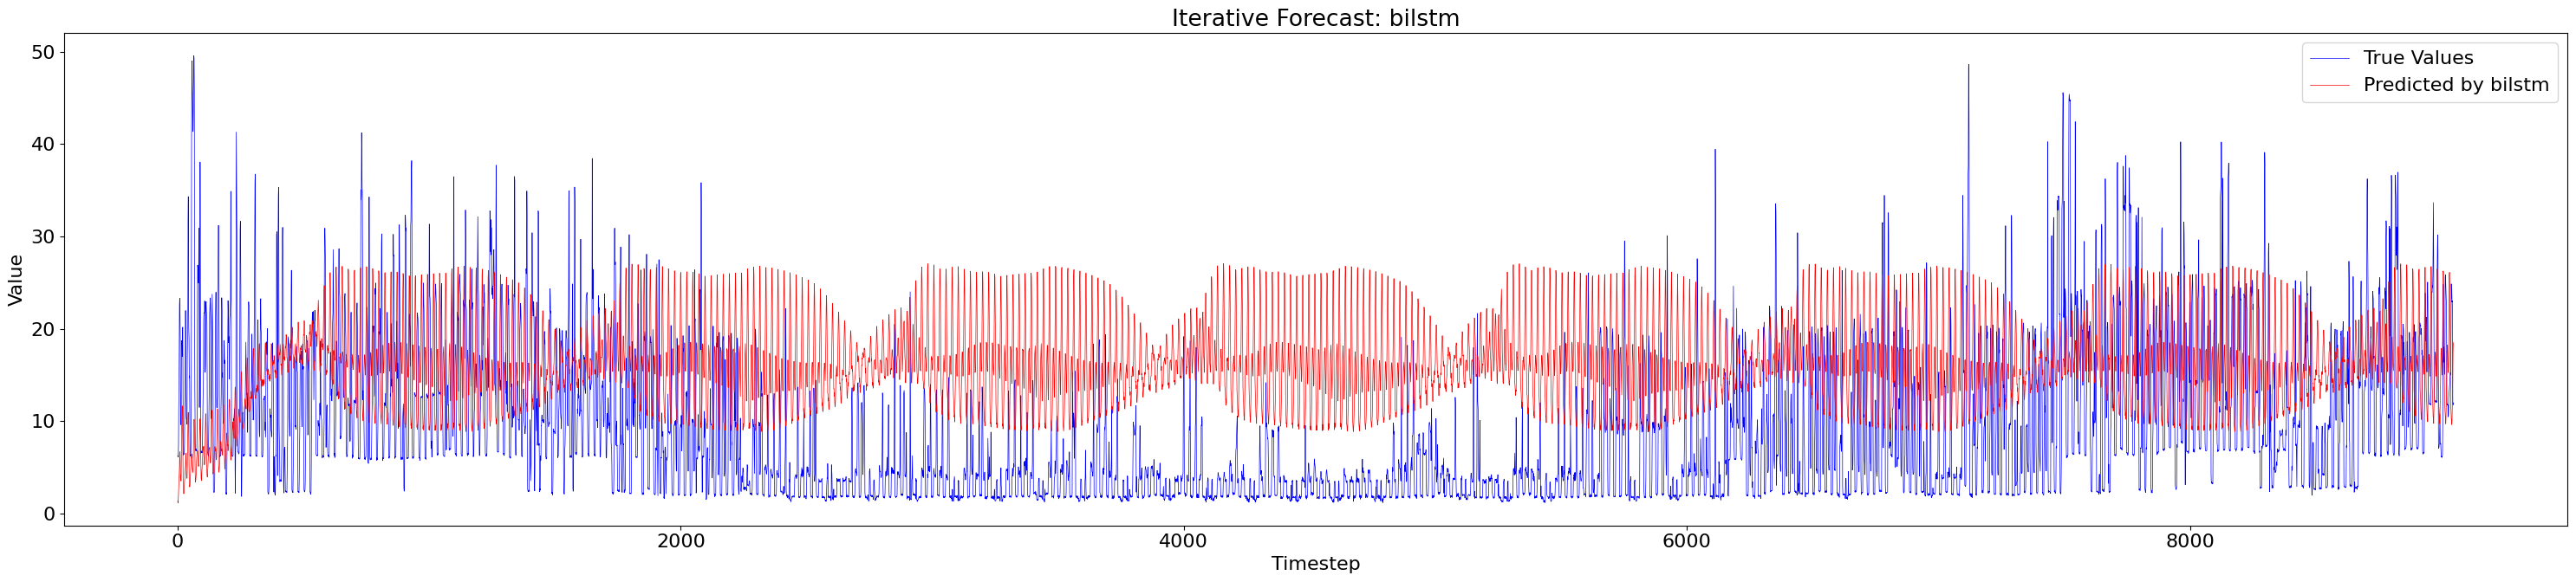

📊 Evaluation Metrics for bilstm:
MAE:  8.2761
RMSE: 10.5121
MAPE: 97.58%
Evaluating cnn_bilstm with horizon rolling forecast...
🔁 Running iterative forecast for cnn_bilstm with input_window=24, forecast_horizon=24


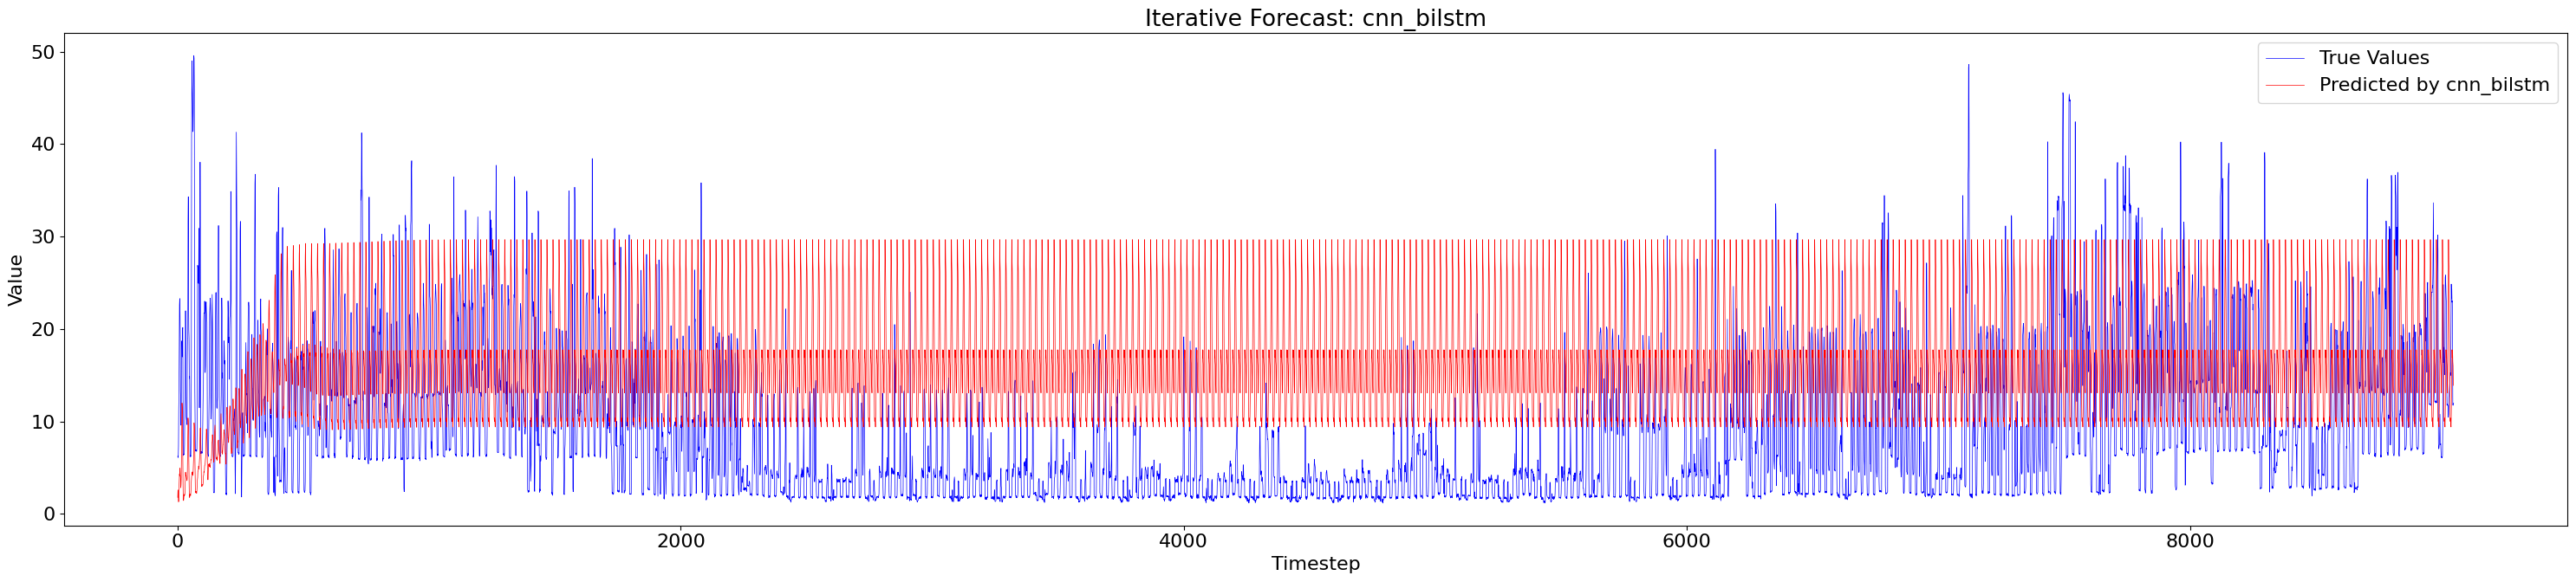

📊 Evaluation Metrics for cnn_bilstm:
MAE:  8.9953
RMSE: 11.3926
MAPE: 105.23%


In [ ]:
input_window = n_input
forecast_horizon = horizon

# Prepare X_test and y_test from test set
X_test, y_test = convert_train_val(test, input_window, forecast_horizon)
X_val, _ = convert_train_val(val, input_window, forecast_horizon)

results = []

for name, model in models:
    model_name = name
    print(f"Evaluating {model_name} with horizon rolling forecast...")

    # Use last input from training as starting point
    initial_input = X_val[-1:].copy()  # shape: (1, window, features)

    print(f"🔁 Running iterative forecast for {model_name} with input_window={input_window}, forecast_horizon={forecast_horizon}")

    # Get true values for the rolling horizon
    true_rescaled = scaler.inverse_transform(y_test[:, :forecast_horizon])

    # Forecast with rolling strategy
    preds_rescaled = horizon_rolling_forecast(
        model=model,
        initial_input=initial_input,
        X_test=X_test,
        forecast_horizon=forecast_horizon,
        input_window=input_window,
        scaler=scaler
    )

    plot_iterative(true_rescaled[:, 0], preds_rescaled, model_name)

    # Flatten for evaluation
    true_flat = true_rescaled.reshape(-1)[:len(preds_rescaled)]
    preds_flat = preds_rescaled.reshape(-1)

    # Evaluation
    mae = mean_absolute_error(true_flat, preds_flat)
    rmse = np.sqrt(mean_squared_error(true_flat, preds_flat))
    mape = np.mean(np.abs((true_flat - preds_flat) / (true_flat + 1e-8))) * 100

    results.append({
        "model": model_name,
        "lookback": input_window,
        "lookahead": forecast_horizon,
        "mae": mae,
        "rmse": rmse,
        "mape": mape
    })

    print(f"📊 Evaluation Metrics for {model_name}:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")


In [46]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv('forecasting_results.csv', index=False)